# Correlation Analysis

In [2]:
## Load Data and preparing datasets

# Import for Load Data
from os import listdir
from os.path import isfile, join
import pandas as pd
# Import for Split Data into Training and Testing Samples
from sklearn.model_selection import train_test_split

# Import for Construct a black-box model (Regression and Random Forests)
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

train_dataset = pd.read_csv(("../../datasets/lucene-2.9.0.csv"), index_col = 'File')
test_dataset = pd.read_csv(("../../datasets/lucene-3.0.0.csv"), index_col = 'File')

outcome = 'RealBug'
features = ['OWN_COMMIT', 'Added_lines', 'CountClassCoupled', 'AvgLine', 'RatioCommentToCode']

# process outcome to 0 and 1
train_dataset[outcome] = pd.Categorical(train_dataset[outcome])
train_dataset[outcome] = train_dataset[outcome].cat.codes

test_dataset[outcome] = pd.Categorical(test_dataset[outcome])
test_dataset[outcome] = test_dataset[outcome].cat.codes

X_train = train_dataset.loc[:, features]
X_test = test_dataset.loc[:, features]

y_train = train_dataset.loc[:, outcome]
y_test = test_dataset.loc[:, outcome]


# commits - # of commits that modify the file of interest
# Added lines - # of added lines of code
# Count class coupled - # of classes that interact or couple with the class of interest
# LOC - # of lines of code
# RatioCommentToCode - The ratio of lines of comments to lines of code
features = ['nCommit', 'AddedLOC', 'nCoupledClass', 'LOC', 'CommentToCodeRatio']

X_train.columns = features
X_test.columns = features
training_data = pd.concat([X_train, y_train], axis=1)
testing_data = pd.concat([X_test, y_test], axis=1)

## Construct a black-box model (Random Forests)

# random forests
rf_model = RandomForestClassifier(random_state=1234, n_jobs = 10)
rf_model.fit(X_train, y_train)  

RandomForestClassifier(n_jobs=10, random_state=1234)

### Collinearity (Pairwise Correlation)

Collinearity is a phenomenon in which one metric can be linearly predicted by another metric. 
There are several correlation tests that can detect collinearity between metrics. For example, Pearson correlation test, Spearman correlation test, and Kendall Tau correlation test.
Below, we provide a tutorial for using and visualising Spearman correlation test.

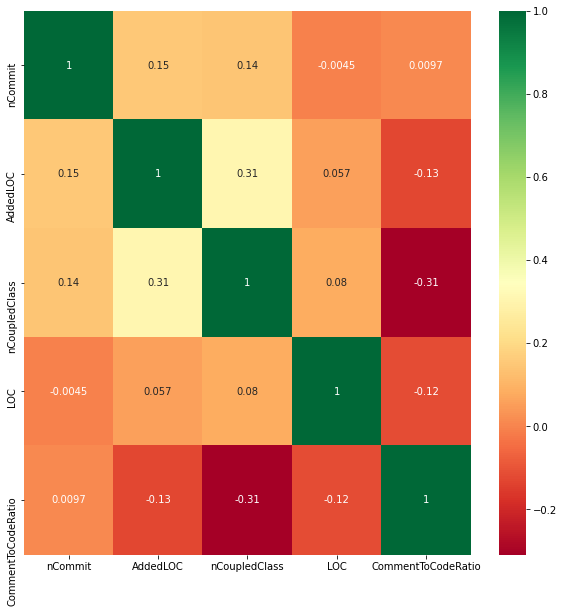

In [7]:
# Import for Correlation tests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# There are 3 options for the parameter setting of method as follows:
# pearson : standard correlation coefficient
# kendall : Kendall Tau correlation coefficient
# spearman : Spearman rank correlation
corrmat = X_train.corr(method='spearman')
top_corr_features = corrmat.index
plt.figure(figsize=(10,10))
#plot heat map
g=sns.heatmap(X_train[top_corr_features].corr(),annot=True,cmap="RdYlGn")

### Multicollinearity

Multicollinearity is a phenomenon in which one metric can be linearly predicted by a combination of two or more metrics. 
Multicollinearity can be detected using Variance Inflation Factor (VIF) analysis {cite}`fox1992generalized`.
The idea behind variance inflation factor analysis is to construct an ordinary least square regression to predict a metric by using the other metrics in the dataset.
Having a model that is well fit indicates that the metric can be predicted by other metrics, linearly highly-correlated with other metrics.
There are 3 steps in variance inflation factor analysis.

*(Step 1) Construct a regression model for each metric.*
For each metric, we construct a model using the other metrics to predict that particular metric.

*(Step 2) Compute a VIF score for each metric.*
The VIF score for each metric is computed using the following formula: $\mathrm{VIF} = \frac{1}{1 - \mathrm{R}^2}$, where $\mathrm{R}^2$ is the explanatory power of the regression model from Step 1.
A high VIF score of a metric indicates that a given metric can be accurately predicted by the other metrics.
Thus, that given metric is considered redundant and should be removed from our model.

*(Step 3) Remove metrics with a VIF score that is higher than a given threshold.*
We remove metrics with a VIF score that is higher than a given threshold.
We use a VIF threshold of 5 to determine the magnitude of multi-collinearity, as it is suggested by Fox {cite}`fox2015applied`.
Then, we repeat the above three steps until the VIF scores of all remaining metrics are lower than the pre-defined threshold.

In [59]:
# Import for VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import random

# Prepare a dataframe for VIF
X_VIF = add_constant(X_train)

# Simulate a multicollinearity situation of LOC, A, and B
X_VIF['A'] = [2 * x_i + random.random() for x_i in X_VIF['LOC']]
X_VIF['B'] = [3 * x_i + random.random() for x_i in X_VIF['LOC']]

# Calculate VIF scores
vif_scores = pd.DataFrame([variance_inflation_factor(X_VIF.values, i) 
               for i in range(X_VIF.shape[1])], 
              index=X_VIF.columns)
# Prepare a final dataframe of VIF scores
vif_scores.reset_index(inplace = True)
vif_scores.columns = ['Feature', 'VIFscore']
vif_scores = vif_scores.loc[vif_scores['Feature'] != 'const', :]
vif_scores.sort_values(by = ['Feature'], ascending = False)

,Feature,VIFscore
3,nCoupledClass,1.222543
1,nCommit,1.040746
4,LOC,113905.910899
5,CommentToCodeRatio,1.123840
7,B,82271.933165
2,AddedLOC,1.126917
6,A,34025.146679


In this example, we observe that LOC, A, and B are problematic with the VIF scores of above 5.
To mitigate multicollinearity, we need to exclude one metric with the highest VIF score, i.e., LOC.
We iteratively repeat the process as described above.

In [117]:
# Import for VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import random

# Prepare a dataframe for VIF
X_VIF = add_constant(X_train)

# Simulate a multicollinearity situation of LOC, A, and B
X_VIF['A'] = [2 * x_i + random.random() for x_i in X_VIF['LOC']]
X_VIF['B'] = [3 * x_i + random.random() for x_i in X_VIF['LOC']]

selected_features = X_VIF.columns

# Stepwise-VIF
print('Stepwise VIF START')
count = 1
while True:
    # Calculate VIF scores
    vif_scores = pd.DataFrame([variance_inflation_factor(X_VIF.values, i) 
                   for i in range(X_VIF.shape[1])], 
                  index=X_VIF.columns)
    # Prepare a final dataframe of VIF scores
    vif_scores.reset_index(inplace = True)
    vif_scores.columns = ['Feature', 'VIFscore']
    vif_scores = vif_scores.loc[vif_scores['Feature'] != 'const', :]
    vif_scores.sort_values(by = ['VIFscore'], ascending = False, inplace = True)
    
    # Find features that have their VIF scores of above 5.0
    filtered_vif_scores = vif_scores[vif_scores['VIFscore'] >= 5.0]
    
    # Terminate when there is no features with the VIF scores of above 5.0
    if len(filtered_vif_scores) == 0:
        break
        
    # exclude the metric with the highest VIF score
    metric_to_exclude = list(filtered_vif_scores['Feature'].head(1))[0]
    
    
    print('Step', count,'- exclude', str(metric_to_exclude))
    count = count + 1
        
    selected_features = list(set(selected_features) - set([metric_to_exclude]))
    
    X_VIF = X_VIF.loc[:, selected_features]
print('The following features are selected according to Stepwise VIF with the VIF threshold value of 5:')
print(vif_scores)

Stepwise VIF START
Step 1 - exclude LOC
Step 2 - exclude A
The following features are selected according to Stepwise VIF with the VIF threshold value of 5:
              Feature  VIFscore
4       nCoupledClass  1.220623
0            AddedLOC  1.122381
2  CommentToCodeRatio  1.120922
3             nCommit  1.039821
5                   B  1.017022


### AutoSpearman: An automated feature selection approach that address collinearity and multicollinearity


Jiarpakdee *et al.* {cite}`jiarpakdee2018icsme`{cite}`jiarpakdee2020impactfss` [@jiarpakdee2018autospearman] introduce , an
automated metric selection approach based on the Spearman rank
correlation test and the VIF analysis for statistical inference. 
The high-level concept of can be summarised into 2 parts:

*(Part 1) Automatically select non-correlated metrics based on a
Spearman rank correlation test.* We first measure the correlation of all
metrics using the Spearman rank correlation test ($\rho$) (*cf.* Line
2). We use the interpretation of correlation coefficients ($|\rho|$) as
provided by Kraemer {cite}`kraemer2003measures`---i.e., a Spearman
correlation coefficient of above or equal to 0.7 is considered a strong
correlation. Thus, we only consider the pairs that have an absolute
Spearman correlation coefficient of above or equal to the threshold
value ($sp.t$) of 0.7.

To automatically select non-correlated metrics based on the Spearman
rank correlation test, we start from the pair that has the highest
Spearman correlation coefficient. Since the two
correlated metrics under examination can be linearly predicted with each
other, one of these two metrics must be removed. Thus, we select the
metric that has the lowest average values of the absolute Spearman
correlation coefficients of the other metrics that are not included in
the pair. That means the removed metric is another metric
in the pair that is not selected. Since the removed
metric may be correlated with the other metrics, we remove any pairs of
metrics that are correlated with the removed metric.
Finally, we exclude the removed metric from the set of the remaining
metrics ($M'$). We repeat this process until all pairs of
metrics have their Spearman correlation coefficient below a threshold
value of 0.7.

*(Part 2) Automatically select non-correlated metrics based on a
Variance Inflation Factor analysis.* We first measure the magnitude of
multicollinearity of the remaining metrics ($M'$) from `Part 1` using
the Variance Inflation Factor analysis (*cf.* Line 12). We use a VIF
threshold value ($vif.t$) of 5 to identify the presence of
multicollinearity, as suggested by Fox {cite}`fox2015applied`.

To automatically remove correlated metrics from the Variance Inflation
Factor analysis, we identify the removed metric as the metric that has
the highest VIF score. We then exclude the removed
metric from the set of the remaining metrics ($M'$). We
apply the VIF analysis on the remaining metrics until none of the
remaining metrics have their VIF scores above or equal to the threshold
value. Finally,  produces a subset of non-correlated
metrics based on the Spearman rank correlation test and the VIF analysis
($M'$).

Similar to filter-based feature selection techniques, *Part 1*
of  measures the correlation of all metrics using the Spearman rank
correlation test regardless of model construction. Similar to
wrapper-based feature selection techniques, *Part 2* of  constructs
regression models to measure the magnitude of multicollinearity of
metrics. Thus, we consider  as a hybrid feature selection technique
(both filter-based and wrapper-based).


TODO - include Tutorials for AutoSpearman